In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

lucky_7 = 7

random.seed(lucky_7)
np.random.seed(lucky_7)
warnings.filterwarnings("ignore")

In [2]:
shhs1_dataset_df = pd.read_csv("shhs1-dataset-0.21.0.csv")
odi_df = pd.read_csv("data/shhs/polysomnography/edfs/shhs1/ODI.csv")

In [3]:
shhs1_dataset_df = shhs1_dataset_df.set_index("nsrrid")
shhs1_dataset_df.head()

,pptid,ecgdate,lvh3_1,lvh3_3,st4_1_3,st5_1_3,lvhst,mob1,part2deg,mob2,...,eoglqual,chinqual,oximqual,posqual,lightoff,oximet51,monitor_id,headbox_id,rcrdtime,psg_month
nsrrid,,,,,,,,,,,,,,,,,,,,,
200001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,96.0,18.0,18.0,7:16:00,6
200002,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,4,4,NaN,94.0,17.0,17.0,9:00:00,1
200003,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,1.0,95.0,17.0,17.0,7:10:00,2
200004,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,3,3,3,0.0,96.0,19.0,19.0,5:58:00,4
200005,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,4,4,4,0.0,96.0,18.0,18.0,7:57:00,3


In [4]:
odi_df.head()

,Unnamed: 0,OxygenDesaturationIndex
0,200005,3.099631
1,200003,2.287893
2,200002,10.120482
3,200004,1.645714
4,200017,0.378947


In [5]:
odi_df = odi_df.set_index(odi_df.columns[0])
odi_df.head()

,OxygenDesaturationIndex
Unnamed: 0,
200005,3.099631
200003,2.287893
200002,10.120482
200004,1.645714
200017,0.378947


In [6]:
df = shhs1_dataset_df.merge(right=odi_df, how="inner", left_index=True, right_index=True).loc[:, ["age_s1", "gender", "OxygenDesaturationIndex", "ahi_o0h3"]]

In [7]:
print(shhs1_dataset_df.shape[0], odi_df.shape[0], df.shape[0])

5804 497 497


In [8]:
df.head()

,age_s1,gender,OxygenDesaturationIndex,ahi_o0h3
200001,55,1,1.328413,4.314248
200002,78,1,10.120482,31.318681
200003,77,2,2.287893,8.870293
200004,48,1,1.645714,2.990033
200005,66,2,3.099631,6.000000


In [9]:
df["ahi_o0h3"] = df["ahi_o0h3"].map(lambda x: 1 if x >= 15 else 0)

In [10]:
df.head()

,age_s1,gender,OxygenDesaturationIndex,ahi_o0h3
200001,55,1,1.328413,0
200002,78,1,10.120482,1
200003,77,2,2.287893,0
200004,48,1,1.645714,0
200005,66,2,3.099631,0


In [11]:
X = df.drop(columns=["ahi_o0h3"])
y = df["ahi_o0h3"]

In [12]:
X.head()

,age_s1,gender,OxygenDesaturationIndex
200001,55,1,1.328413
200002,78,1,10.120482
200003,77,2,2.287893
200004,48,1,1.645714
200005,66,2,3.099631


In [13]:
y.head()

200001    0
200002    1
200003    0
200004    0
200005    0
Name: ahi_o0h3, dtype: int64

In [14]:
y.value_counts()

ahi_o0h3
0    335
1    162
Name: count, dtype: int64

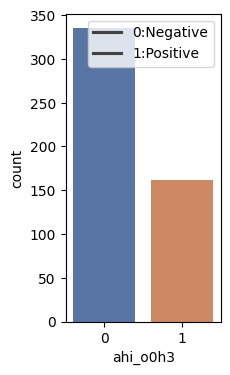

In [44]:
plt.figure(figsize=(2, 4))
sns.barplot(y.value_counts(), palette=['#4c72b0', '#dd8452'])
plt.legend(["0:Negative", "1:Positive"])
plt.grid(False)
plt.show(block=False)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(397, 3) (397,) (100, 3) (100,)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, y_train.shape, X_train_scaled.shape, y_test.shape)

(397, 3) (397,) (397, 3) (100,)


In [18]:
def plot_cm(cm):
    plt.figure(figsize=(2.5,2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [19]:
from sklearn.metrics import accuracy_score

def compute_folds(X, y, folds):
    if folds > len(X):
        raise ValueError(f"{folds} > {len(X)} IMPOSSIBLE")
    
    X_folds = np.array_split(X, folds)
    y_folds = np.array_split(y, folds)

    print(f"Number of folds: {folds}")
    return X_folds, y_folds

def cross_validation(model_class, X, y, folds):
    X_folds, y_folds = compute_folds(X, y, folds)
    acc_scores = []

    for i in range(folds):
        # Create training data by excluding fold i
        X_train = np.vstack(X_folds[:i] + X_folds[i+1:])
        y_train = np.hstack(y_folds[:i] + y_folds[i+1:])

        # Validation data = fold i
        X_val = X_folds[i]
        y_val = y_folds[i]

        # Reinitialize model to avoid accumulation across folds
        model = model_class()

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        acc_scores.append(acc)
        print(f"Fold {i} Accuracy: {acc:.4f}")

    print(f"\nAverage Accuracy: {np.mean(acc_scores):.4f}")

In [20]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.78      0.90      0.83        67
           1       0.70      0.48      0.57        33

    accuracy                           0.76       100
   macro avg       0.74      0.69      0.70       100
weighted avg       0.75      0.76      0.75       100



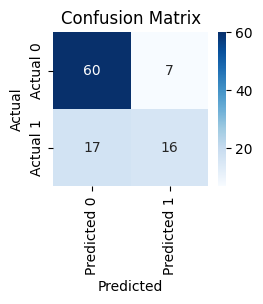

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_model.predict(X_test_scaled)
print(classification_report(y_true=y_test, y_pred=y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_cm(cm)


In [22]:
cross_validation(LogisticRegression, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 Accuracy: 0.7250
Fold 1 Accuracy: 0.8000
Fold 2 Accuracy: 0.8250
Fold 3 Accuracy: 0.7500
Fold 4 Accuracy: 0.8500
Fold 5 Accuracy: 0.8750
Fold 6 Accuracy: 0.7500
Fold 7 Accuracy: 0.8462
Fold 8 Accuracy: 0.7692
Fold 9 Accuracy: 0.7436

Average Accuracy: 0.7934


In [23]:
from sklearn.tree import DecisionTreeClassifier

dtree_model = DecisionTreeClassifier()
dtree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       0.78      0.85      0.81        67
           1       0.63      0.52      0.57        33

    accuracy                           0.74       100
   macro avg       0.71      0.68      0.69       100
weighted avg       0.73      0.74      0.73       100



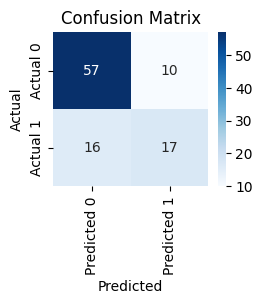

In [24]:
y_pred = dtree_model.predict(X_test_scaled)
print(classification_report(y_true=y_test, y_pred=y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_cm(cm)

In [25]:
cross_validation(DecisionTreeClassifier, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 Accuracy: 0.6000
Fold 1 Accuracy: 0.6750
Fold 2 Accuracy: 0.8500
Fold 3 Accuracy: 0.7000
Fold 4 Accuracy: 0.8250
Fold 5 Accuracy: 0.7250
Fold 6 Accuracy: 0.8250
Fold 7 Accuracy: 0.6667
Fold 8 Accuracy: 0.7436
Fold 9 Accuracy: 0.6410

Average Accuracy: 0.7251


In [26]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.81      0.87      0.83        67
           1       0.68      0.58      0.62        33

    accuracy                           0.77       100
   macro avg       0.74      0.72      0.73       100
weighted avg       0.76      0.77      0.76       100



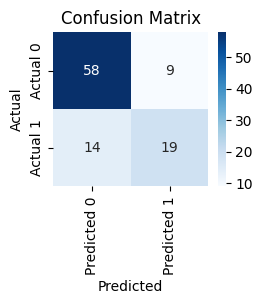

In [27]:
y_pred = xgb_model.predict(X_test_scaled)
print(classification_report(y_true=y_test, y_pred=y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_cm(cm)

In [28]:
cross_validation(XGBClassifier, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 Accuracy: 0.6250


Fold 1 Accuracy: 0.7500
Fold 2 Accuracy: 0.8750
Fold 3 Accuracy: 0.8000
Fold 4 Accuracy: 0.8500
Fold 5 Accuracy: 0.8000
Fold 6 Accuracy: 0.7500
Fold 7 Accuracy: 0.6410
Fold 8 Accuracy: 0.8462
Fold 9 Accuracy: 0.6667

Average Accuracy: 0.7604


In [29]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(sampling_strategy="all")
brf_model.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(sampling_strategy='all')

              precision    recall  f1-score   support

           0       0.85      0.78      0.81        67
           1       0.62      0.73      0.67        33

    accuracy                           0.76       100
   macro avg       0.73      0.75      0.74       100
weighted avg       0.77      0.76      0.76       100



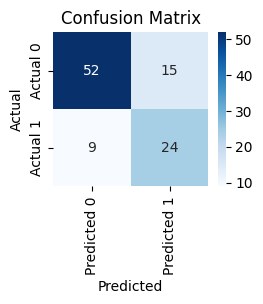

In [30]:
y_pred = brf_model.predict(X_test_scaled)
print(classification_report(y_true=y_test, y_pred=y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_cm(cm)

In [31]:
cross_validation(BalancedRandomForestClassifier, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 Accuracy: 0.6000
Fold 1 Accuracy: 0.7500
Fold 2 Accuracy: 0.8500
Fold 3 Accuracy: 0.8500
Fold 4 Accuracy: 0.8750
Fold 5 Accuracy: 0.7250
Fold 6 Accuracy: 0.8000
Fold 7 Accuracy: 0.7949
Fold 8 Accuracy: 0.8462
Fold 9 Accuracy: 0.6923

Average Accuracy: 0.7783


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        67
           1       0.64      0.55      0.59        33

    accuracy                           0.75       100
   macro avg       0.72      0.70      0.71       100
weighted avg       0.74      0.75      0.74       100



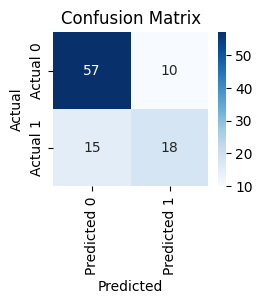

In [33]:
y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_true=y_test, y_pred=y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_cm(cm)

In [34]:
cross_validation(RandomForestClassifier, X_train_scaled, y_train, 10)

Number of folds: 10
Fold 0 Accuracy: 0.6500
Fold 1 Accuracy: 0.7500
Fold 2 Accuracy: 0.8750
Fold 3 Accuracy: 0.8250
Fold 4 Accuracy: 0.8750
Fold 5 Accuracy: 0.8250
Fold 6 Accuracy: 0.7750
Fold 7 Accuracy: 0.7179
Fold 8 Accuracy: 0.7949
Fold 9 Accuracy: 0.6667

Average Accuracy: 0.7754
